In [1]:
# Import libraries
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
timeframe = "hourly"
symbols = ["SPY"]
systems = ["Strat_Breakout"]#, "Strat_Breakout"]
starting_balance = 10000
risk_per_trade = 0.02 # Risking 2% per trade
# List to store the various pivot point levels
pivot_point_levels = ['S3', 'S2', 'S1', 'PP', 'R1', 'R2', 'R3']
breakout_pivot = 4
reversal_pivot = 2

In [3]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    return df

In [4]:
def calculate_inputs(df, pivots_timeframe="daily"):
    # Capture the original timezone before converting to UTC
    original_timezone = df.index[0].tzinfo  # Get timezone info from the first index entry

    # Ensure the index is in datetime format and convert to UTC
    df.index = pd.to_datetime(df.index, utc=True)

    # Determine resampling rule based on timeframe
    resample_rule = 'D' if pivots_timeframe == "daily" else 'W-FRI'
    
    # Resample to the chosen timeframe to calculate pivot points
    resampled_df = df.resample(resample_rule).agg({'High': 'max', 'Low': 'min', 'Close': 'last'})

    # Calculate pivot points
    resampled_df['PP'] = (resampled_df['High'] + resampled_df['Low'] + resampled_df['Close']) / 3
    resampled_df['R1'] = (2 * resampled_df['PP']) - resampled_df['Low']
    resampled_df['S1'] = (2 * resampled_df['PP']) - resampled_df['High']
    resampled_df['R2'] = resampled_df['PP'] + (resampled_df['High'] - resampled_df['Low'])
    resampled_df['S2'] = resampled_df['PP'] - (resampled_df['High'] - resampled_df['Low'])
    resampled_df['R3'] = resampled_df['R1'] + (resampled_df['High'] - resampled_df['Low'])
    resampled_df['S3'] = resampled_df['S1'] - (resampled_df['High'] - resampled_df['Low'])

    # Shift pivot point data forward to align with the next period
    pivot_points = resampled_df[['PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3']].shift(1)

    # Forward fill missing values to ensure no NaNs for non-trading days
    pivot_points.ffill(inplace=True)  # This ensures weekends/holidays inherit previous values

    # Ensure both DataFrames have a "date" column for merging
    df['Date'] = df.index.normalize()  # Normalize to remove the time part
    pivot_points['Date'] = resampled_df.index.normalize()

    # Step 3: Merge on the "Date" column
    merged_df = df.merge(pivot_points, on='Date', how='left')

    # Forward fill missing values in the merged DataFrame
    merged_df.ffill(inplace=True)

    # Step 4: Restore the original DateTime index
    merged_df.set_index(df.index, inplace=True)

    # Step 5: Drop the extra "Date" column if not needed
    merged_df.drop(columns=['Date'], inplace=True)

    # Step 6: Convert the timezone of the merged DataFrame back to the original timezone
    merged_df.index = merged_df.index.tz_convert(original_timezone)  # Convert back to the original timezone

    return merged_df


In [5]:
def get_pivot(level):
    level = max(0, min(level, 6)) # Clamp level between 0 and 6 to avoid index errors
    return pivot_point_levels[level]

In [6]:
def generate_signals(df, s, res=1, sup=1):

    # Entry conditions
    c1 = (df['Open'] < df['R1']) & (df['Close'] > df['R1']) # Breakout through resistance level
    c2 = (df['Open'] > df['S1']) & (df['Close'] < df['S1']) # Test of support level

    # Entries depend on the strategy
    if s == "Strat_Breakout":
        df[f"{s}_Signal"] = c1.shift(1)
        entry_pivot = breakout_pivot
    elif s == "Strat_Reversal":
        df[f"{s}_Signal"] = c2.shift(1)
        entry_pivot = reversal_pivot
    
    # Generate exits
    if s == "Strat_Breakout":
        df['SL'] = df[get_pivot(entry_pivot - sup)]
        df['TP'] = df[get_pivot(entry_pivot + res)]
    elif s == "Strat_Reversal":
        df['SL'] = df[get_pivot(entry_pivot - sup)]
        df['TP'] = df[get_pivot(entry_pivot + res)]

    return df

In [7]:
def generate_trades(df, s, starting_balance, risk_per_trade):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    
    #iterate through rows to work out entries and exits
    for i, row in df.iterrows():
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated at the close and enter at the same time
            if row[f"{s}_Signal"] == True:
                entry_date = i
                entry_price = row.Open
                sl = row.SL
                tp = row.TP

                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                position_size = risk_amount / abs(entry_price - sl)  # Position size in units

                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            low = row.Low
            high = row.High
            # Track the open change while the trade is open to monitor balance during the trade.
            open_change[i] = low / entry_price

            # Calculate unrealized PnL
            floating_pnl = (high - entry_price) * position_size
            equity = balance + floating_pnl  # Update equity dynamically

            # Calculate unrealized PnL
            #check if stop is hit
            if low <= sl:
                #first check for a gap down
                if row.Open <= sl:
                    exit_price = row.Open
                else:
                    exit_price = sl
                trade_open = False

            # Now do the same check for take profit
            elif high >= tp:
                #first check for a gap up
                if row.Open >= tp:
                    exit_price = row.Open
                else:
                    exit_price = tp
                trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = i
                trade_open = False
                pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                balance += pnl  # Update balance with PnL

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    #trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values
    change_ser = pd.Series(open_change, name=f"{s}_Change")

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries, change_ser], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    #fill all the NaN return values with 1 as there was no loss on those days
    df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).fillna(method='ffill')
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).fillna(method='ffill')

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True
    
    return df, trades

In [8]:
def backtest(price, res, sup):

    #calculate strategy inputs
    price = calculate_inputs(price, pivots_timeframe="daily")

    for s in systems:
        #generate signals
        price = generate_signals(price, s, res, sup)
        #generate trades
        price, trades = generate_trades(price, s, starting_balance=starting_balance, risk_per_trade=risk_per_trade)
    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [9]:
results = []
prog = 0
# max levels should be:
# for breakout, max res is 2, max sup is 4. Range can be set to 3 and 5 because the upper value in the range is not inclusive
# for reversal it is the other way around
res_levels = np.arange(1, 2, 1)
sup_levels = np.arange(1, 2, 1)
max_prog = len(symbols) * len(res_levels) * len(sup_levels)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for res in res_levels:
        for sup in sup_levels:
            result, trades = backtest(price, res, sup)
            results.append(result)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 0.13513755798339844 s


In [10]:
#calculate metrics
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "hourly":
        N = 252 * 6.5 # number of trading hours per year (assuming 9:30 - 16:00 for NYSE)
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [11]:
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

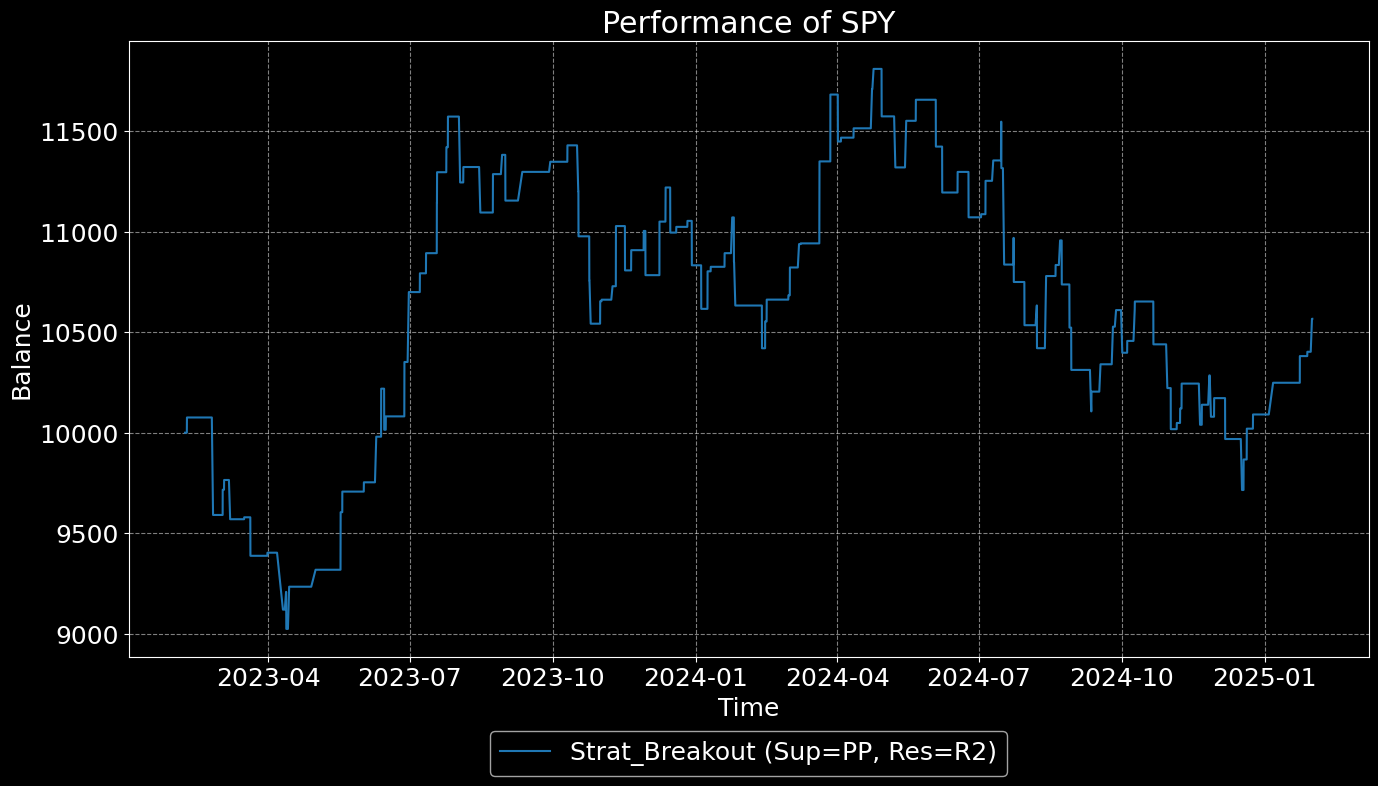

In [12]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

# Use a colormap for distinct colors
cmap = plt.get_cmap("tab10")  # You can try 'tab20', 'viridis', 'plasma', etc.

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    total_lines = len(res_levels) * len(sup_levels) * len(systems)  # Total lines to plot
    colors = [cmap(i / total_lines) for i in range(total_lines)]  # Generate distinct colors

    color_idx = 0  # Track color index

    for res in res_levels:
        for sup in sup_levels:
            for s in systems:
                result_idx = count * len(res_levels) * len(sup_levels) + list(res_levels).index(res) * len(sup_levels) + list(sup_levels).index(sup)

                if result_idx >= len(results):  
                    continue  # Prevent out-of-bounds error

                if s == "Strat_Breakout":
                    entry_pivot = breakout_pivot
                elif s == "Strat_Reversal":
                    entry_pivot = reversal_pivot
                sl_pivot = get_pivot(entry_pivot - sup)
                tp_pivot = get_pivot(entry_pivot + res)
                
                label = f"{s} (Sup={sl_pivot}, Res={tp_pivot})"  
                plt.plot(results[result_idx][f"{s}_Bal"], color=colors[color_idx], label=label)  # Use generated colors
                legend_entries.append(label)

                color_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [13]:
sys_metrics_df

,Strat_Breakout
Start_Balance,10000.00
Final_Balance,10566.76
Total_Return,5.67
Annual_Return,2.82
Time_in_Market,6.39
Return_By_Exposure,44.13
Max_Drawdown,-17.74
Return_Over_Drawdown,0.16
RBE_Over_Drawdown,2.49
Sharpe,0.04
